In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_original = df = pd.read_csv("iris.csv")
df_original['variety'].groupby(df_original['variety']).count()

variety
Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

In [41]:
plant = 'Virginica'
def define_target(x):
    if x == plant:
        return 1
    else:
        return 0

cost_list = []

df['target'] = df['variety'].apply(define_target)
df['intercept'] = 1
#cost_list = []
column_names = df.columns
for col in column_names:
    if col != 'target' and col != 'intercept' and col != 'variety':
        df[col] = (df[col]-df[col].mean())/(df[col].max()-df[col].min())
y = df['target'].to_numpy().reshape(-1,1)
x = df[['intercept','sepal.length','sepal.width','petal.length','petal.width']].to_numpy()
beta = np.random.standard_normal(x.shape[1]).reshape(-1,1)
i=0
while i <1500:
    log_odds = np.matmul(x,beta)
    p = 1/(1+np.exp(-log_odds))
    beta_update = np.matmul(x.transpose(),y-p)
    beta += 0.01*beta_update
    cost = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    cost_list.append(cost)
    i+=1
    
# Note: How does cost function behave with predicted probabilities 
# Scenario 1: probabilities are absolutely off i.e. when y=1 p=0 and y=0 p=1
# # Sum(y x log(p)+(1-y) x log(1-p)) OR Sum(1 X log(0) + 1xlog(1-1)) OR Cost -> -infinity
# Scenario 2: 1 of the probabilities are off i.e. when y=1 p=1 and y=0 p=1
# # Sum(y x log(p)+(1-y) x log(1-p)) OR Sum(1 X log(1) + 1xlog(1-1)) OR Cost -> -infinity
# Scenario 3: Both are correctly predicted i.e. when y=1 p=1 and y=0 p=0
# # Sum(y x log(p)+(1-y) x log(1-p)) OR Sum(1 X log(1) + 1xlog(1)) OR Cost -> 0
# Hence as we move from misclassification to correct classification Cost moves from -infinity to 0

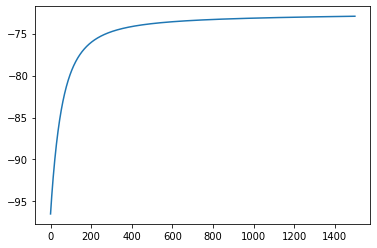

In [33]:
plt.plot(cost_list)

In [42]:
prob_set1 = [x.item() for x in p]
target = [x.item() for x in y]
correct = 0

for i in range(len(target)):
    if prob_set1[i]>0.5: 
         out = 1
    else:
        out = 0
    if target[i]== out:
        correct+=1
        
str(correct/len(target)*100)+"%"

'97.33333333333334%'

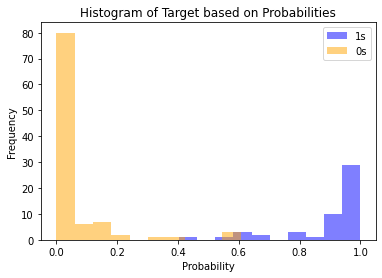

In [43]:
# Choosing a threshold
# For y = 0 plot a density plot of the predicted values
# For y = 1 plot a density plot of the predicted values

data = {'target': target,
        'prob': prob_set1}

# Create DataFrame
df = pd.DataFrame(data)

# Separate the data into two based on the values in Column1 (1s and 0s)
ones = df[df['target'] == 1]['prob']
zeros = df[df['target'] == 0]['prob']

# Plot histogram
plt.hist(ones, bins=10, alpha=0.5, label='1s', color='blue')
plt.hist(zeros, bins=10, alpha=0.5, label='0s', color='orange')

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Target based on Probabilities')
plt.legend()

# Show plot
plt.show()

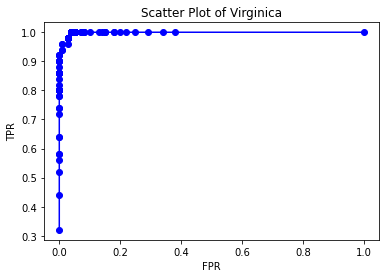

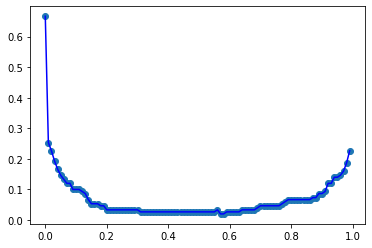

In [44]:
# ROC Curve - FPR vs TPR
thresold_list = []
FPR = []
TPR = []
misclassification_error = []
p_0 = df[df['target']==0]['prob']
p_1 = df[df['target']==1]['prob']
i = 0
while i <=1:
    thresold_list.append(i)
    i+=0.01
    
for t in thresold_list:
    FPR.append(len([x for x in p_0 if x>=t])/len(p_0))
    TPR.append(len([x for x in p_1 if x>=t])/len(p_1))
    misclassification_error.append((len([x for x in p_0 if x>=t]) + len([x for x in p_1 if x<=t]))/(len(p_0)+len(p_1)))
    
# Create a scatter plot
plt.scatter(FPR, TPR, color='blue')
plt.plot(FPR, TPR, color='blue', linestyle='-', label='Connecting line')

# Add labels and title
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'Scatter Plot of {plant}')

# Show plot
plt.show()


plt.scatter(thresold_list,misclassification_error)
plt.plot(thresold_list,misclassification_error, color='blue', linestyle='-', label='Connecting line')

In [45]:
# Choosing the threshold
threshold = dict(zip(misclassification_error,thresold_list))
threshold[min(list(threshold.keys()))]

0.5800000000000003

In [46]:
#AUC
from sklearn.metrics import roc_auc_score
data = {'FPR': FPR,
        'TPR': TPR}

# Create DataFrame
df = pd.DataFrame(data).sort_values(by=['FPR'])
df['lagged_FPR'] = df['FPR'].shift(1)
df['lagged_TPR'] = df['TPR'].shift(1)
df['Area'] = 0.5*((df['lagged_TPR']+df['TPR'])*(df['FPR']-df['lagged_FPR'])) #Trapizoid Area Calculation


df['Area'].sum(), roc_auc_score(target,prob_set1)

(0.997, 0.9984)

In [39]:
# McFadden's R-Square
ratio = len(df_original[df_original['variety']==plant])/len(df_original[df_original['variety']!=plant])
p_mean = 1/(1+np.exp(-ratio))
cost_mean = np.sum(y * np.log(p_mean) + (1 - y) * np.log(1 - p_mean))
1 - cost/cost_mean

0.39788075291582203